本文共分为3个部分，具体如下

一、优选基金，该部分主要进行基金池的筛选

二、挑选优选基金的超配股，该部分主要进行基金重仓股的分析

三、构造优选基金的超配组合，该部分主要依据基金重仓股构建组合，分析其收益、风格、行业信息

# 优选基金

该部分内容包括:

1.1 基金池筛选

1.2 基金规模初选

1.3 选基指标

##  基金池筛选

本报告主要研究基金重仓股是否能带来超额收益，主要观察公募基金，不仅是因为A股市场上公募基金是最大的机构投资者，而且公募基金信息披露透明。按照规定，公募基金要及时发布季度报告、半年度报告以及年度报告，在季度报告中要披露前十大持仓股票和前五大持仓股票，在半年度报告以及年度报告中，要披露所有持仓情况。

根据基金类型选取股票型基金和混合型基金。混合型基金需要过滤非偏股型的基金。

提取2005~2020年的所有公募基金公开数据，进行以下筛选：
1. 保留主动型基金，去除被动型基金，同时剔除封闭式基金，剔除分级基金，FOF基金等
2. 保留连续4季度持股比例在70%仓位之上的基金

筛选完成后，符合要求的基金数量从5000余只下降到640只（2020年第三季度）

In [1]:
import pymongo
import QUANTAXIS as QA
import sys
sys.path.append('/root/workspace/QUANTAXIS/src')
from utils import *
from stock_head import *
from jqdatasdk import *
from QUANTAXIS import *

start_date = QA.QA_util_get_next_trade_date('2009-01-01')
end_date = QA.QA_util_get_pre_trade_date(datetime.date.today().strftime("%Y-%m-%d"))
# raw_data_dir = '../data/raw_data/'
SELECT_RATE = [0.05, 0.1] ##重仓股的选择比例
print(start_date, end_date)

you are using non-interactive mdoel quantaxis
auth success 
{'total': 1000000, 'spare': 903357}
2009-01-05 2021-08-10


## 1.基金池筛选

In [2]:
## 获取基金基本信息，去掉分级基金、FOF、QDII、指数基金、指数增强基金
fund_info = QA_fetch_fund_info()
fund_info = fund_info[~(fund_info.operate_mode.isin(['QDII', 'FOF', 'ETF']))]
types_list = ['lof', 'open_fund', 'stock_fund',  'mixture_fund']
securities_info = QA_fetch_securities_info(sec_type = types_list)
securities_info.index = securities_info.index.map(lambda x: x.split('.')[0])
securities_info = securities_info[~(securities_info.display_name.str.contains('QDII') | securities_info.display_name.str.contains('FOF')
                        | securities_info.display_name.str.contains('分级') | securities_info.display_name.str.contains('美元') 
                        | securities_info.display_name.str.contains('指数'))]
fund_info = pd.merge(fund_info['operate_mode'], securities_info,
                    left_index=True, right_index = True, how='inner')
print(fund_info.shape)

(7059, 5)


In [3]:
# 获取基金规模信息
fund_port = QA_fetch_fund_portfolio(code = fund_info.index.tolist())
fund_port = fund_port[~fund_port.report_type.isnull()][['name','report_type','pub_date','equity_rate','total_asset']]
fund_port['equity_rate'] = fund_port['equity_rate'].fillna(0)
##del some not standard report date
fund_port = fund_port[fund_port.index.get_level_values(0).map(lambda x: x[-5:] in ['03-31', '06-30', '09-30', '12-31'])]
fund_port.shape

(96270, 5)

In [4]:
## 获取过去四个季度持股比例均超过67%的基金
equity_ratio_df = pd.pivot_table(fund_port, index=fund_port.index.get_level_values(0),
                                 columns=fund_port.index.get_level_values(1), 
                                 values='equity_rate')
equity_ratio_df = (equity_ratio_df >= (0.67 * 100))  #### 2/3 ratio
equity_ratio_df = (equity_ratio_df.rolling(4).sum() == 4) ### 4 quarters
equity_ratio_df = equity_ratio_df.stack().rename('isStockFund')
fund_port = pd.merge(fund_port, equity_ratio_df, left_index=True, right_index=True, how='left')

In [5]:
### filter the fund by isStock ratio
isStockSum = fund_port.groupby('code')['isStockFund'].sum()
isStockCnt = fund_port.groupby('code')['isStockFund'].count()
isStockPert = isStockSum * 1.0 / isStockCnt  ## isStockFund ratio

filter_list = list(set(isStockSum[isStockSum > 0].index.tolist()) & set(isStockPert[isStockPert >= 0.5].index.tolist()))
# filter_list = list(set(isStockSum[isStockSum > 0].index.tolist()) )
# print(filter_list)

In [6]:
fund_port = fund_port[fund_port.index.get_level_values(1).isin(filter_list)]
# print(fund_port.query("period_end=='2021-06-30' & isStockFund == True").shape)
print(fund_port.groupby('period_end').count().head(1))
print(fund_port.groupby('period_end').count().tail(1))
print(fund_port.shape)

            name  report_type  pub_date  equity_rate  total_asset  isStockFund
period_end                                                                    
2008-12-31   190          190       190          190          190          190
            name  report_type  pub_date  equity_rate  total_asset  isStockFund
period_end                                                                    
2021-06-30  1818         1818      1818         1818         1818         1818
(43155, 6)


In [7]:
## 根据筛选出的基金code，获取连续净值
# fund_nav = QA_fetch_fund_NAV(code=fund_port.index.levels[1].unique().tolist())['refactor_net_value'].reset_index()
fund_nav = QA_fetch_fund_NAV(code=filter_list)['refactor_net_value'].reset_index()

fund_nav = fund_nav[((fund_nav.date >= start_date) & (fund_nav.date < end_date))]
fund_nav = pd.pivot_table(fund_nav, index=['date'], columns=['code'], values=['refactor_net_value'])
fund_nav = fund_nav.pct_change(fill_method='ffill').stack().rename(columns={'refactor_net_value': 'adjNavChgPct'}) * 100
print(fund_nav.shape)
# print(fund_nav.head(5))

(2700205, 1)


In [8]:
# 获取季度信息, return this quarter and next quarter
def get_current_quarter(x):
    year, month = x[:4], x[5:7]
    if month <= '03':
        return year + '-03-31'
    elif month <= '06':
        return year + '-06-30'
    elif month <= '09':
        return year + '-09-30'
    else:
        return year + '-12-31'
def get_last_quarter(x):
    year, month = x[:4], x[5:7]
    if month <= '03':
        return str(int(year)-1) + '-12-31'
    elif month <= '06':
        return year + '-03-31'
    elif month <= '09':
        return year + '-06-30'
    else:
        return year + '-09-30'
def get_next_quarter(x):
    year, month = x[:4], x[5:7]
    if month <= '03':
        return year + '-06-30'
    elif month <= '06':
        return year + '-09-30'
    elif month <= '09':
        return year + '-12-31'
    else:
        return str(int(year)+1) + '-03-31'
## calculate yearly sp based on dayily return
def cal_sp(x, rtn_col, riskfree_rate=0.03):
    year_days=240
    if len(x) <= year_days * 0.8:
        return np.nan
    
    x['cumRet'] = (1 + x[rtn_col]).cumprod()
#     if len(x['cumRet']) == 0:
#         return np.nan    
    
    annualized_return = (round(x['cumRet'].values[-1], 4) ** (year_days/len(x['cumRet']))) - 1.0
    volatility = np.std(x[rtn_col]) * np.sqrt(year_days)
    if volatility == 0:
        return None
    sp = (annualized_return - riskfree_rate) / volatility        
    return sp    
## calculate periodly rtn
def cal_ret(x, month_days=21):
    if len(x) < month_days * 0.5:
        return np.nan        
    if x.min() < -0.12 or x.max() > 0.12:
        return np.nan
    return (1 + x).prod() - 1

In [9]:
# 最近一季度收益率，过去一年的夏普率 
def cal_fund_ret(all_fund_nav, begin_date, end_date):
    all_quarter_list = [str(year) + quarter \
                        for year in range(int(begin_date[:4]), int(end_date[:4]) + 1)\
                        for quarter in ['-03-31', '-06-30', '-09-30', '-12-31']]
    data_list = []
    for i, end_quarter in enumerate(all_quarter_list):
        if end_quarter > end_date:
            break
        begin_quarter = str(int(end_quarter[:4])-1) + end_quarter[4:] ## one years before

        ## only one year to cal sharp ratio
        df = all_fund_nav[(all_fund_nav["date"] >= begin_quarter) & (all_fund_nav["date"] <= end_quarter)].copy()
        ##one year's NAV daily!
        df['adjNavChgPct'] = df['adjNavChgPct'].fillna(0) / 100.0
        df['curQuarter'] = df['date'].apply(lambda x: get_current_quarter(x))
        df['nextQuarter'] = df['date'].apply(lambda x: get_next_quarter(x))
        
        ## df contain one year's data
        sp = df.groupby('code').apply(lambda x: cal_sp(x, 'adjNavChgPct')) ## year's sharp
        ## the newest quarter
        quarter_df = df[(df['curQuarter'] == end_quarter)]  
        ret = quarter_df.groupby('code')['adjNavChgPct'].apply(lambda x: cal_ret(x))
        
        ## concat to new df
        quarter_perf_df = pd.concat([sp, ret], axis=1).dropna(how='any').reset_index()
        quarter_perf_df.columns = ['code', 'SP', 'quarter ret']
        quarter_perf_df['reportDate'] = end_quarter

        data_list.append(quarter_perf_df)
        print(f'{begin_quarter}:{end_quarter} , df {df.shape}, code {len(df.code.unique())} ,perf_df.shape {quarter_perf_df.shape}')
    
    perf_df = pd.concat(data_list).drop_duplicates(subset=['code', 'reportDate']).dropna(
        subset=['SP', 'quarter ret'], how='all')
    perf_df['curQuarter'] = perf_df['reportDate'].apply(lambda x: get_current_quarter(x))
    perf_df['nextQuarter'] = perf_df['reportDate'].apply(lambda x: get_next_quarter(x))
    perf_df = pd.merge(
        perf_df[['code', 'reportDate', 'SP', 'quarter ret', 'nextQuarter']].rename(columns={'nextQuarter': 'nextReportDate', 'quarter ret':'lastQRet'}),
        perf_df[['code', 'curQuarter', 'quarter ret']].rename(columns={'quarter ret': 'nextQRet'}),
        how='left', left_on=['code', 'nextReportDate'], right_on=['code', 'curQuarter']).sort_values(
        ['code', 'reportDate']).drop(['curQuarter'], axis=1).dropna(subset=['SP']).fillna({'nextQRet': 0}).set_index(['reportDate', 'code'])
#     perf_df.to_csv('s_perf_df.csv')
    return perf_df

In [10]:
perf_df = cal_fund_ret(fund_nav.reset_index(), start_date, end_date)
print(perf_df.shape)

2008-03-31:2009-03-31 , df (11064, 5), code 204 ,perf_df.shape (0, 4)
2008-06-30:2009-06-30 , df (23910, 5), code 219 ,perf_df.shape (0, 4)
2008-09-30:2009-09-30 , df (38784, 5), code 232 ,perf_df.shape (0, 4)
2008-12-31:2009-12-31 , df (53056, 5), code 250 ,perf_df.shape (202, 4)
2009-03-31:2010-03-31 , df (57025, 5), code 263 ,perf_df.shape (215, 4)
2009-06-30:2010-06-30 , df (60536, 5), code 284 ,perf_df.shape (229, 4)
2009-09-30:2010-09-30 , df (63915, 5), code 296 ,perf_df.shape (242, 4)
2009-12-31:2010-12-31 , df (68041, 5), code 312 ,perf_df.shape (260, 4)
2010-03-31:2011-03-31 , df (71578, 5), code 322 ,perf_df.shape (277, 4)
2010-06-30:2011-06-30 , df (75361, 5), code 338 ,perf_df.shape (293, 4)
2010-09-30:2011-09-30 , df (79589, 5), code 355 ,perf_df.shape (308, 4)
2010-12-31:2011-12-31 , df (82965, 5), code 369 ,perf_df.shape (321, 4)
2011-03-31:2012-03-31 , df (86250, 5), code 382 ,perf_df.shape (337, 4)
2011-06-30:2012-06-30 , df (89167, 5), code 400 ,perf_df.shape (350, 4

In [11]:
df = pd.merge(fund_port.rename_axis(index={'period_end':'reportDate'}), perf_df, left_index=True, right_index=True)
df = df[df['isStockFund']==True].drop('isStockFund', axis=1)
df.to_csv('fund_df.csv', encoding='gbk')
print(df.shape)
df.head(5)

(32436, 9)


name report_type    pub_date  equity_rate   total_asset        SP  lastQRet nextReportDate  nextQRet
reportDate code                                                                                                                   
2009-12-31 000021  华夏优势增长股票型证券投资基金        第四季度  2010-01-21        91.87  1.690606e+10  1.819152  0.161323     2010-03-31 -0.046889
           000031    华夏复兴股票型证券投资基金        第四季度  2010-01-21        90.24  4.925003e+09  3.365355  0.208927     2010-03-31  0.017282
           002011    华夏红利混合型证券投资基金        第四季度  2010-01-21        90.48  2.730181e+10  2.724458  0.187931     2010-03-31 -0.008355
           020001     国泰金鹰增长证券投资基金        第四季度  2010-01-20        88.04  1.131284e+09  3.155926  0.218573     2010-03-31 -0.009036
           020005   国泰金马稳健回报证券投资基金        第四季度  2010-01-20        90.48  8.960523e+09  3.267469  0.151707     2010-03-31 -0.029638

In [12]:
df.tail(5)

name report_type    pub_date  equity_rate   total_asset        SP  lastQRet nextReportDate  nextQRet
reportDate code                                                                                                                             
2021-06-30 960016         交银施罗德成长混合型证券投资基金H类        第二季度  2021-07-20        76.02  3.152940e+09  0.498580  0.062515     2021-09-30       0.0
           960018          大成内需增长混合型证券投资基金H类        第二季度  2021-07-21        85.68  4.292123e+08  1.482094  0.113726     2021-09-30       0.0
           960020          南方优选价值混合型证券投资基金H类        第二季度  2021-07-21        79.61  1.783989e+09  0.500412  0.160763     2021-09-30       0.0
           960021  富兰克林国海潜力组合混合型证券投资基金H类-人民币        第二季度  2021-07-21        92.71  3.230355e+09  1.021188  0.093750     2021-09-30       0.0
           960024             嘉实成长收益证券投资基金H类        第二季度  2021-07-20        73.99  3.627378e+09  1.706074  0.195769     2021-09-30       0.0

## 基金规模初选

基金规模是基金的重要考察因素。本节考察基金规模与收益的关系，具体来说，每季度根据基金规模分十组，考察每组下季度的收益，看基金规模与下季度收益是否有相关关系。

In [13]:
# ---------------------------  计算规模与下期收益的关系
# 因子分组的超额收益作bar图
def plot_quantile_excess_return(perf, title, xlabel=u'分位组(1为值最小组)', ylabel=u'分组超额收益'):
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(111)
    
    perf.plot(kind='bar', ax=ax1, legend=False)
    plt.legend(perf.columns, prop=font, loc='best', handlelength=4,
               handletextpad=1, borderpad=0.5, ncol=2)
    ax1.set_ylabel(ylabel, fontproperties=font, fontsize=16)
    ax1.set_xlabel(xlabel, fontproperties=font, fontsize=16)
    ax1.set_xticks(perf.index)
    ax1.set_yticks(ax1.get_yticks())
#     ax1.set_yticks([str(round(x, 4) * 100) + '0%' for x in ax1.get_yticks()])
    ax1.set_yticklabels([str(round(x, 4) * 100) + '0%' for x in ax1.get_yticks()], 
                        fontproperties=font, fontsize=14)
    ax1.set_title(title, fontproperties=font, fontsize=16)
    ax1.grid()
    plt.show()
    
def plot_bar_lines(ax1_x, ax1_y, ax1_label, ax2_x, ax2_y, ax2_label, title):
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    ind = np.arange(len(ax1_x))
    width = 0.5

    ax1.bar(ind + width / 2.0, ax1_y, width=width, label=ax1_label)
    ax1.legend(loc=2, prop=font)
    ax1.set_xticks(ind + width)
    ax1.set_xticklabels(ax1_x, rotation=90)
    ax1.set_title(title, fontsize=16, fontproperties=font)

    ax2.plot(ind + width, ax2_y, color='r', label=ax2_label)
    ax2.legend(loc=9, prop=font)
    ax2.grid(False)

    plt.show()    
    
# 按factor分组进行绘图, market return 为所有基金收益的mean
def cal_group_ret(data_info, factor_name='total_asset', group=10):
    data_info = data_info.dropna(subset=[factor_name, 'nextQRet'], how='all')
    data_info['group'] = (data_info.groupby('reportDate')[factor_name].apply(
        lambda x: (x.rank(method='first') - 1) / len(x) * group).astype(int)) + 1
    ## 按factor从小到大排序， 分为group组   
    
    group_pref = data_info.groupby(['reportDate', 'group']).apply(lambda x: x['nextQRet'].mean()).reset_index()  ## group return
    group_pref.columns = ['reportDate', 'group', 'nextQRet']    
    market_pref = data_info.groupby(['reportDate']).apply(lambda x: x['nextQRet'].mean()).reset_index()  ## market return
    market_pref.columns = ['reportDate', 'market_ret']    
    merge_pref = pd.merge(group_pref, market_pref, on='reportDate')    
    merge_pref['excessRet'] = merge_pref['nextQRet'] - merge_pref['market_ret']
    group_excess_ret = merge_pref.groupby('group')[['nextQRet', 'excessRet']].mean()
    
    return data_info, merge_pref, group_excess_ret

asset_group_info (32436, 10)
asset_perf_group_info (470, 5)
----------total asset 的quantile分隔点-------------------
0.10    7.029876e+07
0.25    2.034458e+08
0.50    7.155830e+08
0.75    2.058674e+09
1.00    9.200973e+10
Name: total_asset, dtype: float64


QUANTAXIS>> findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


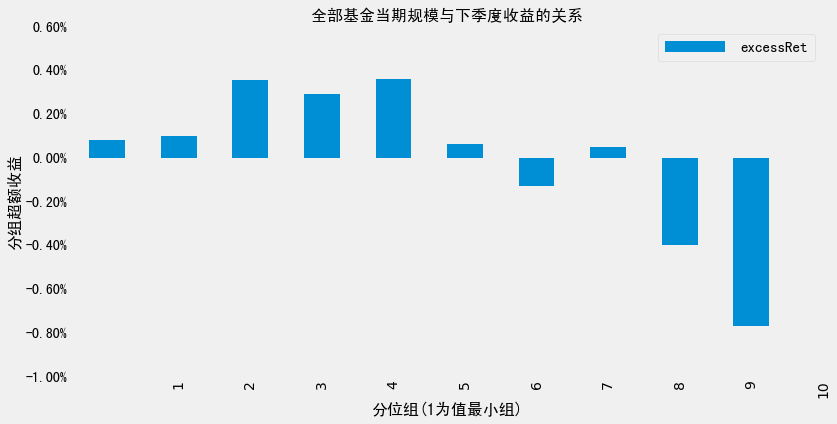

In [14]:
asset_group, asset_perf_group, asset_exret = cal_group_ret(df, 'total_asset')
print("asset_group_info "+str(asset_group.shape))
print('asset_perf_group_info ' + str(asset_perf_group.shape))
# print(asset_perf_group.tail(5))  ## market return is mean of all the funds' return
print('----------total asset 的quantile分隔点-------------------')
print(asset_group['total_asset'].quantile([0.1, 0.25, 0.5, 0.75, 1]))
plot_quantile_excess_return(asset_exret[['excessRet']], u'全部基金当期规模与下季度收益的关系')

* 上图规模分组超额收益显示，基金规模偏大的基金下期收益均不好，中小规模的基金表现要好些。但为了稳健性，后续选取规模10亿-100亿（1e09-1e10）规模的基金进行分析。

after choose_1, the size is 992， the shape is (12842, 10)


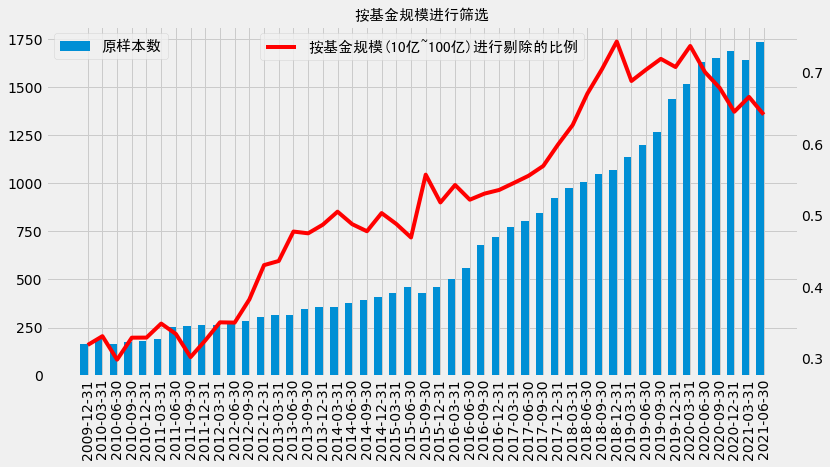

In [15]:
# ---------------------------  展示中等基金数目及按规模筛选比例10亿~100亿
choose_1 = asset_group[(asset_group['total_asset'] > 1e9) & (asset_group['total_asset'] < 1e10)]  #按规模
print(f'after choose_1, the size is {len(choose_1.index.get_level_values(1).unique())}， the shape is {choose_1.shape}')
asset_cnt = asset_group.groupby('reportDate')['name'].count()
choose_1_cnt = choose_1.groupby('reportDate')['name'].count()
data = pd.concat([asset_cnt, (1 - choose_1_cnt * 1.0 / asset_cnt)], axis=1).dropna()
data.columns = ['cnt', 'ratio']

plot_bar_lines(asset_cnt.index, data['cnt'].values, u'原样本数', 
              asset_cnt.index, data['ratio'].values, u'按基金规模(10亿~100亿)进行剔除的比例',
              u'按基金规模进行筛选')
# print(data.tail(2))

In [16]:
# ####---------------------------  展示小规模基金数目及按规模筛选比例1亿到10亿
# choose_1 = asset_group[(asset_group['total_asset'] > 1e8) & (asset_group['total_asset'] < 1e9)]  #按规模
# print(f'after choose_1, the size is {len(choose_1.index.get_level_values(1).unique())}， the shape is {choose_1.shape}')
# asset_cnt = asset_group.groupby('reportDate')['name'].count()
# choose_1_cnt = choose_1.groupby('reportDate')['name'].count()
# data = pd.concat([asset_cnt, (1 - choose_1_cnt * 1.0 / asset_cnt)], axis=1).dropna()
# data.columns = ['cnt', 'ratio']

# plot_bar_lines(asset_cnt.index, data['cnt'].values, u'原样本数', 
#               asset_cnt.index, data['ratio'].values, u'按基金规模(1亿~10亿)进行剔除的比例',
#               u'按基金规模进行筛选')


上图展示了每季度的基金池数目与按规模剔除的比例，可以看到基金池个数近些年稳步提升，剔除的比例也越来越低，主要是因为小规模的基金占比越来越高。

## 选基指标

上节按照规模初筛基金池，本小节依据研报按照基金过去一年的夏普率作为分组依据，考察每组的下期收益情况。

下图可以看出夏普率高的基金，分组超额收益（本组收益-平均收益）也较高，有着不错的单调线性关系。因此后续按照夏普率分组TOP10%作为筛选后的优选基金池。

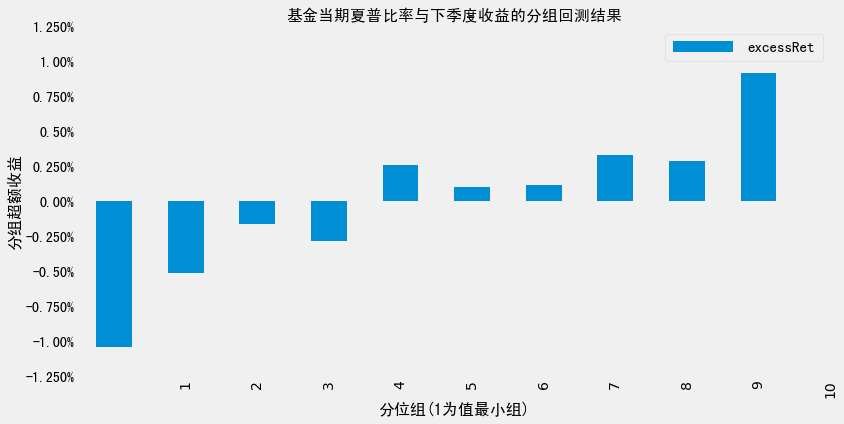

after choose 2, the Number of chosen fund is 480， the SP&rtn shape is (1263, 10)


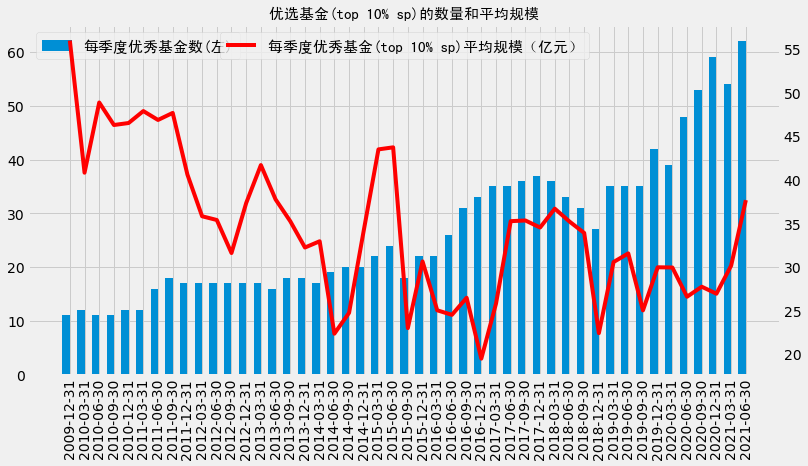

In [17]:
# ---------------------------  展示基金(资金规模筛选后的)当期夏普比率与下季度收益的分组回测结果
choose_1, sp_asset_perf, sp_asset_ret = cal_group_ret(choose_1, 'SP')
plot_quantile_excess_return(sp_asset_ret[['excessRet']], u'基金当期夏普比率与下季度收益的分组回测结果')

# ---------------------------  展示优选基金的数量和平均规模
# choose_2 = choose_1.query("group==10").copy()  ## sharp ratio最高的10%
choose_2 = choose_1[choose_1['group'] == 10]
print(f'after choose 2, the Number of chosen fund is {len(choose_2.index.get_level_values(1).unique())}， the SP&rtn shape is {choose_2.shape}')
fund_cnt = choose_2.groupby('reportDate')['name'].count()
avg_asset = choose_2.groupby('reportDate')['total_asset'].mean() / 1e8

plot_bar_lines(fund_cnt.index, fund_cnt.values, u'每季度优秀基金数(左)', 
              avg_asset.index, avg_asset.values, u'每季度优秀基金(top 10% sp)平均规模（亿元）',
              u'优选基金(top 10% sp)的数量和平均规模')


下图分析了夏普率top10%基金构成的等权基金组合的每年超额收益分布图，可以看出在大部分年份，该组合能跑赢等权基金组合，过去10年平均每年能跑赢3.7%。

下图展示了我们每季度按照夏普率筛选的基金数目及规模，可以看到每季度大概筛选40-60只基金，规模均在4亿-5亿之间

choose 1:规模在1亿~10亿之间

choose 2：每次季报的SP在前10%

after choose 2, the Number of chosen fund is 351， the SP&rtn shape is (998, 10)

# 挑选优选基金的超配股

该部分内容包括:

2.1 优选基金的前十大重仓股

2.2 优选基金的超配股(top 10%)

2.3 超配股的超配股(top 30% of top 10%)

首先按照上述每季度选取的基金，调取相应的季度持仓信息

In [18]:
### 提取持仓信息，去掉银行及金融行业
fund_detail = QA_fetch_fund_portfolio_stock(code = choose_2.index.get_level_values(1).unique().tolist())
fund_detail = fund_detail[(fund_detail['report_type'] != '年度' ) & (fund_detail['report_type'] != '半年度')]
fund_detail.index.names = ['reportDate', 'code']
choose_detail = pd.merge(choose_2.drop(columns=['total_asset', 'group']),
                         fund_detail[['rank', 'symbol', 'name', 'market_cap','proportion']].rename(columns = {'symbol':'secID', 'name':'secName'}), 
                         left_index=True, right_index=True, how='left')
##是否绝对持仓比例
# choose_detail['normRatio'] = round((choose_detail['proportion'] / choose_detail['equity_rate']) * 100, 2)
choose_detail['normRatio'] = round(choose_detail['proportion'] , 2)
choose_detail['tradeDate'] = choose_detail.groupby('reportDate')['pub_date'].transform(max)

industry = QA_fetch_industry_by_stock(stock_code = choose_detail['secID'].unique().tolist()).reset_index().astype(str)
industry = industry[(industry.src == 'sw') & (industry.level == 'l1')]
choose_detail = pd.merge(choose_detail.reset_index(),
                         industry[['date', 'code', 'industry_code']].rename(columns={'date':'reportDate','code':'secID'}),
                         left_on = ['reportDate', 'secID'], right_on = ['reportDate', 'secID'],
                         how = 'left').set_index(['reportDate', 'code']).sort_index()
## 去掉801780银行 801790金融 801190 金融服务
choose_detail = choose_detail[(choose_detail.industry_code != '801780') & (choose_detail.industry_code != '801790') & (choose_detail.industry_code != '801190')]
print(choose_detail.shape)

(11639, 16)


## 优选基金的前十大重仓股

下节分析了优选基金的前十大重仓股, 取基金池中每只基金的重仓股并集作为最终该季度的股票池，发现近些年重仓股数量稳定在200只左右，说明优质基金有抱团的倾向；从重仓股的平均持仓权重来看，最近几期在5.5%~6%左右，单个基金的持仓分散度有所降低


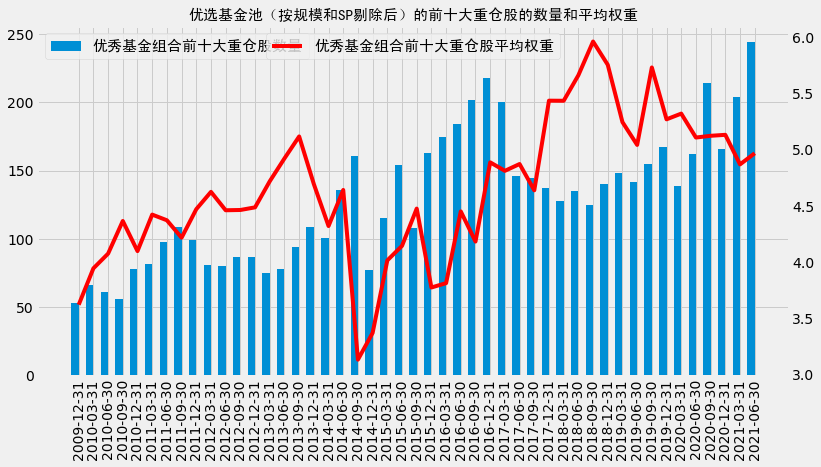

In [19]:
## 重仓股合并个数，计算单只重仓股的平均权重
top10_stat = choose_detail.reset_index().groupby('reportDate').apply(
                        lambda x: pd.Series(
                            index=['fundCnt', 'stockCnt', 'weights mean', 'SP mean'],
                            data=[len(x['code'].unique()), len(x['secID'].unique()),  
                                  x['normRatio'].mean(), x['SP'].mean()]))
plot_bar_lines(top10_stat.index, top10_stat['stockCnt'].values, u'优秀基金组合前十大重仓股数量',
              top10_stat.index, top10_stat['weights mean'].values, u'优秀基金组合前十大重仓股平均权重',
              u'优选基金池（按规模和SP剔除后）的前十大重仓股的数量和平均权重')
# print(top10_stat)

In [20]:
### 处理十大重仓股为mean rank，sum rank
choose_res = choose_detail.reset_index().groupby(['reportDate', 'secID']).apply(
    lambda x: pd.Series(index=['fundCnt', 'weights mean', 'weights sum', 'SP mean'],
                        data=[len(x['code'].unique()),  x['normRatio'].mean(), 
                              x['normRatio'].sum(), x['SP'].mean()])).reset_index()
choose_res = pd.merge(choose_res,
                       choose_detail.reset_index()[['reportDate', 'secID', 'secName', 'tradeDate']],                       
                       left_on=['reportDate', 'secID'], right_on=['reportDate', 'secID'], how='left').drop_duplicates()

## score: Rank(mean)+Rank(sum)
choose_res['mean rank'] = choose_res.groupby(['reportDate'])['weights mean'].rank(axis=0, method='first', ascending=False)
choose_res['sum rank'] = choose_res.groupby(['reportDate'])['weights sum'].rank(axis=0, method='first', ascending=False)
choose_res['score'] = choose_res['mean rank'] + choose_res['sum rank']

choose_res.shape

(6088, 11)

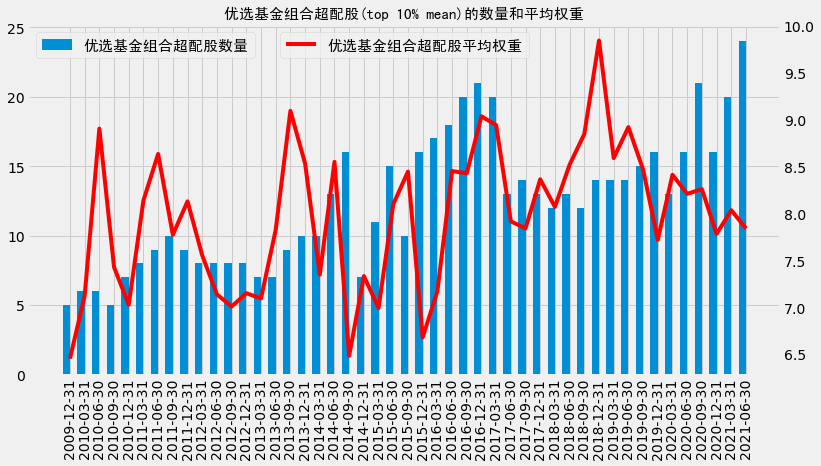

In [21]:
## top10 mean
top10_mean = choose_res.sort_values(['reportDate', 'weights mean'], ascending=[True, False])
top10_mean = top10_mean.groupby('reportDate').apply(lambda x: x.head(int(x.shape[0] * 0.1))).reset_index(drop=True)
top10_mean.to_csv('top10_mean.csv', encoding='gbk')
top10mean_stat = top10_mean.groupby('reportDate').apply(
    lambda x: pd.Series(index=['cnt', 'weight'], data=[len(x['secID'].unique()), x['weights mean'].mean()]))
plot_bar_lines(top10mean_stat.index, top10mean_stat['cnt'].values, u'优选基金组合超配股数量',
              top10mean_stat.index, top10mean_stat['weight'].values, u'优选基金组合超配股平均权重',
              u'优选基金组合超配股(top 10% mean)的数量和平均权重')

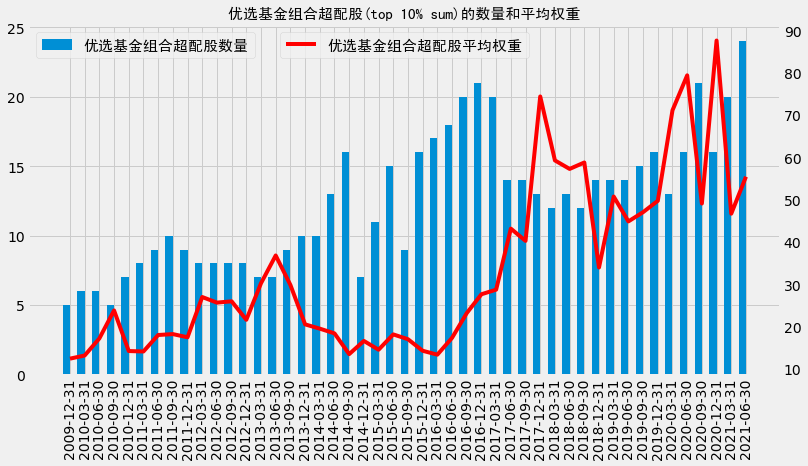

In [22]:
## top10 sum
top10_sum = choose_res.sort_values(['reportDate', 'weights sum'], ascending=[True, False])
top10_sum = top10_sum.groupby('reportDate').apply(lambda x: x.head(int(x.shape[0] * 0.1))).reset_index(drop=True)
top10_sum.to_csv('top10_sum.csv', encoding='gbk')
top10sum_stat = top10_sum.groupby('reportDate').apply(
    lambda x: pd.Series(index=['cnt', 'weight'], data=[len(x['secID'].unique()), x['weights sum'].mean()]))
plot_bar_lines(top10sum_stat.index, top10sum_stat['cnt'].values, u'优选基金组合超配股数量',
              top10sum_stat.index, top10sum_stat['weight'].values, u'优选基金组合超配股平均权重',
              u'优选基金组合超配股(top 10% sum)的数量和平均权重')

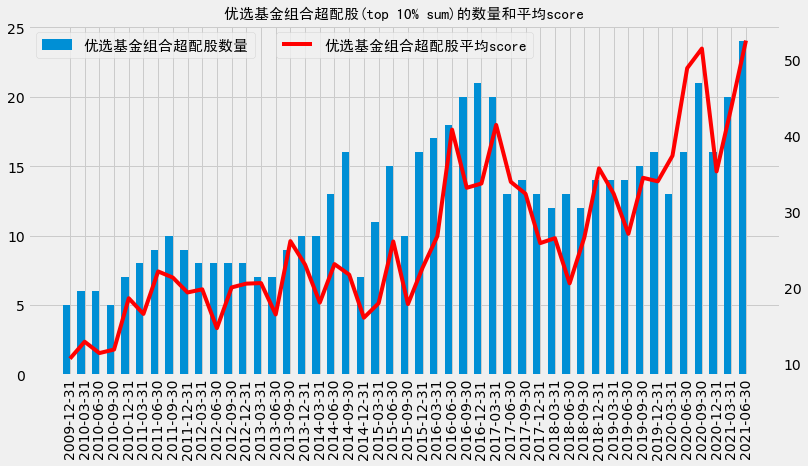

In [23]:
## top10 score: Rank(mean) + rank(sum)
top10_score = choose_res.sort_values(['reportDate', 'score'], ascending=[True, True])
top10_score = top10_score.groupby('reportDate').apply(lambda x: x.head(int(x.shape[0] * 0.1))).reset_index(drop=True)
top10_score.to_csv('top10_score.csv', encoding='gbk')
top10score_stat = top10_score.groupby('reportDate').apply(
    lambda x: pd.Series(index=['cnt', 'mean'], data=[len(x['secID'].unique()), x['score'].mean()]))
plot_bar_lines(top10score_stat.index, top10score_stat['cnt'].values, u'优选基金组合超配股数量',
              top10score_stat.index, top10score_stat['mean'].values, u'优选基金组合超配股平均score',
              u'优选基金组合超配股(top 10% sum)的数量和平均score')

In [24]:
top10_score[top10_score['reportDate'] == top10_score['reportDate'].max()].head(15)

,reportDate,secID,fundCnt,weights mean,weights sum,SP mean,secName,tradeDate,mean rank,sum rank,score
561,2021-06-30,300750,39.0,7.340000,286.26,3.170064,宁德时代,2021-07-21,12.0,1.0,13.0
562,2021-06-30,300146,3.0,8.990000,26.97,3.325286,汤臣倍健,2021-07-21,5.0,24.0,29.0
563,2021-06-30,601012,18.0,6.371667,114.69,3.107164,隆基股份,2021-07-21,31.0,2.0,33.0
564,2021-06-30,600600,4.0,7.290000,29.16,3.243289,青岛啤酒,2021-07-21,15.0,20.0,35.0
565,2021-06-30,002304,6.0,6.628333,39.77,3.474151,洋河股份,2021-07-21,26.0,13.0,39.0
566,2021-06-30,601058,5.0,6.798000,33.99,3.492556,赛轮轮胎,2021-07-21,24.0,15.0,39.0
567,2021-06-30,300014,11.0,6.300000,69.30,3.071535,亿纬锂能,2021-07-21,36.0,4.0,40.0
568,2021-06-30,002088,3.0,7.520000,22.56,3.327973,鲁阳节能,2021-07-21,10.0,32.0,42.0
569,2021-06-30,002241,4.0,7.030000,28.12,3.061694,歌尔股份,2021-07-21,20.0,22.0,42.0
570,2021-06-30,600141,3.0,7.206667,21.62,3.327973,兴发集团,2021-07-21,17.0,33.0,50.0


In [37]:
top10_mean[top10_mean['reportDate'] == top10_mean['reportDate'].max()].head(15)

,reportDate,secID,fundCnt,weights mean,weights sum,SP mean,secName,tradeDate,mean rank,sum rank,score
561,2021-06-30,603885,1.0,10.01,10.01,3.561611,吉祥航空,2021-07-21,1.0,79.0,80.0
562,2021-06-30,002648,1.0,9.75,9.75,2.795186,卫星石化,2021-07-21,2.0,84.0,86.0
563,2021-06-30,02333,1.0,9.30,9.30,3.606551,长城汽车,2021-07-21,3.0,86.0,89.0
564,2021-06-30,601668,1.0,9.12,9.12,3.419380,中国建筑,2021-07-21,4.0,88.0,92.0
565,2021-06-30,300146,3.0,8.99,26.97,3.325286,汤臣倍健,2021-07-21,5.0,24.0,29.0
566,2021-06-30,600315,1.0,8.83,8.83,3.332077,上海家化,2021-07-21,6.0,90.0,96.0
567,2021-06-30,300327,1.0,8.40,8.40,3.069768,中颖电子,2021-07-21,7.0,98.0,105.0
568,2021-06-30,002677,1.0,8.25,8.25,3.332077,浙江美大,2021-07-21,8.0,101.0,109.0
569,2021-06-30,01211,1.0,7.90,7.90,3.926892,比亚迪股份,2021-07-21,9.0,103.0,112.0
570,2021-06-30,002088,3.0,7.52,22.56,3.327973,鲁阳节能,2021-07-21,10.0,32.0,42.0


# backtest by QA

In [25]:
init_cash = 10000000
file_name = 'top10_score.csv'  ##从这取策略的买入卖出数据
portfolio = 'QA_Day1'
strategy_id = 'Fund_score_'+dt.datetime.now().strftime('%Y%m%d%H%M') ##每次运行必须更改，否则覆盖

start_date = QA.QA_util_get_next_trade_date('2013-01-01')
end_date = QA.QA_util_get_pre_trade_date(datetime.date.today().strftime("%Y-%m-%d"))

backtest_dir = './backtest_data/'
if not os.path.exists(backtest_dir):
    os.mkdir(backtest_dir)
print(strategy_id)

Fund_score_202108111642


In [26]:
### 处理持仓文件，增加buyDate和sellDate
def fetch_trade_info(filename):    
    def _get_sell_date(date):
        date = str(pd.to_datetime(date, format='%Y-%m-%d').date())
        if(QA.QA_util_if_trade(date)):
            return date.replace('-', '')
        else:
            return QA.QA_util_get_pre_trade_date(date).replace('-', '')
    
    df = pd.read_csv(filename, index_col=0, encoding='gbk', dtype={'secID':str, 'tradeDate':str})
    sell_date_list = list(df['tradeDate'].unique().tolist())
    last_trade_day = QA.QA_util_get_pre_trade_date(QA.QA_util_datetime_to_strdate(QA.QA_util_date_today())).replace('-', '')
    sell_date_list.append(last_trade_day)
    df['sellDate'] = df['tradeDate'].apply(
        lambda x: _get_sell_date(sell_date_list[sell_date_list.index(x)+1]))
    df['buyDate'] = df['tradeDate'].apply(lambda x: QA.QA_util_get_next_trade_date(x).replace('-', ''))
    df = df[['buyDate', 'sellDate', 'secID']]
    df = df[df['secID'].str.len() == 6] ## drop HONGKONG stock
    df.to_csv(backtest_dir+strategy_id+'_trade_info.csv', encoding='gbk')    
    return df

In [27]:
## strategy
class fundStrategy(QAStrategyStockBase):
    df = pd.DataFrame()
    
    def user_init(self):
        print('---------user init-------')
        self.init_cash = init_cash
        self.hold_in_record = {}        
        self.df = pd.read_csv(backtest_dir+strategy_id+'_trade_info.csv', index_col=0, encoding='gbk', dtype=str)
        
    def parse_xdxr(self, data):
        today = str(data.name[0])[0:10]
        ticker = data.name[1]
        xdxr_df = QA.QA_fetch_stock_xdxr(ticker).query('category=="1" & date==@today')
        if(xdxr_df.empty):
            return
        xdxr_df = xdxr_df[['code', 'fenhong', 'songzhuangu', 'peigu', 'peigujia']]
        
        print('\n++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
        print(xdxr_df)
        if(float(xdxr_df['fenhong']) != 0):
            origin_cash = self.get_cash()
            add_cash = round(float(xdxr_df['fenhong']) * (self.acc.hold[ticker] / 10), 2)
            self.acc.change_cash(add_cash)
            self.acc.cash_available = self.acc.cash[-1]
            print('分红，增加现金%s' %(str(round(self.get_cash() - origin_cash, 2))))            
             
        if(float(xdxr_df['songzhuangu']) != 0):
            origin_hold = self.acc.hold[ticker]
            vol = math.floor(float(xdxr_df['songzhuangu']) * (self.acc.hold[ticker] / 10) / 100) * 100
            self.send_order(direction="BUY", offset="OPEN", code=ticker, price=0, volume=vol)
            print('转增股，增加股票%s股%s' %(self.acc.hold[ticker] - origin_hold, ticker))
            
            
        if(float(xdxr_df['peigu']) != 0 or float(xdxr_df['peigujia'])!=0):
            ####配股，先卖后买，保持仓位。
            last_day = QA.QA_util_get_pre_trade_date(today)
            last_price = float(QA.QA_fetch_stock_day_adv(code=ticker, start=self.start, end=last_day).close.iloc[-1])
            
            origin_position = last_price * self.acc.hold[ticker]
            self.send_order(direction="SELL", offset="CLOSE", code=ticker, price=last_price, volume=self.acc.hold[ticker])
            a, b = self.acc.history_table.iloc[-1, :][['price', 'amount']]
            print('配股前清仓: 卖出价%s, 卖出数量%s， 金额%s'%(a, b, a*b))
            
            new_price = data.close
            new_amount = math.floor(origin_position / new_price /100) * 100
            self.send_order(direction="OPEN", offset="BUY", code=ticker, price=new_price, volume=new_amount)
            a, b = self.acc.history_table.iloc[-1, :][['price', 'amount']]
            print('配股后买入: 买入价%s, 买入数量%s， 金额%s'%(a, b, a*b))            
            
        print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')        
        
  
    def on_bar(self, data):
        today = str(data.name[0])[0:10].replace('-', '')
        ticker = data.name[1]

        if(ticker in self.acc.hold.index):
            self.parse_xdxr(data)            
        
        if(today not in self.df['buyDate'].values and today not in self.df['sellDate'].values):
            return
        
        buy_list = self.df[df['buyDate'] == today]['secID'].tolist()
        sell_list = self.df[df['sellDate'] == today]['secID'].tolist()
        total_list = self.df['secID'].unique().tolist()
        if(ticker not in total_list):
            return        

#         ##1.clear the postion
        if (today in self.df['sellDate'].values and ticker in self.acc.hold.index):
            print('-------today:' +today+' ticker: ' + str(ticker) + ' to sell begin------------')
            print('before cash: %s, price: %s, sell_vol: %s' %(str(round(self.get_cash())), str(data.close), 
                  str(int(self.acc.hold[ticker]))))
            self.send_order(direction="SELL", offset="CLOSE", code=ticker, price=data.close, volume=int(self.acc.hold[ticker]))
#             self.hold_in_record.pop(ticker)
            print('after cash:' + str(round(self.get_cash())))
            print(self.acc.hold)
            if(self.acc.hold.empty):
                print('at %s clear the position successfully!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!' %(today))
            print('--------------------- to sell end ---------------------------------------------\n')
        
#         ##2. long the position
        if (today in self.df['buyDate'].values and ticker in buy_list):
            print('------- today:' +today+' ticker: ' + str(ticker) + ' to buy begin--------------')
            to_buy = list(set(buy_list) - set(self.acc.hold.index.tolist()))
            print('to_buy:  ')
            print(to_buy)
            buy_vol = int(math.floor(math.floor(self.acc.cash_available/len(to_buy)/data.close) / 100) *100)
            print('before cash: %s, price: %s, to_buy: %s, buy_vol: %s' %(str(round(self.get_cash())),
                  str(data.close), str(len(to_buy)), str(buy_vol)))
            
            self.send_order(direction="BUY", offset="OPEN", code=ticker, price=data.close, volume=buy_vol)
            
            print('after cash:' + str(round(self.get_cash())))
            print(self.acc.hold)
            to_buy = list(set(buy_list) - set(self.acc.hold.index.tolist()))
            if(not to_buy):
                print('at %s clear the to_buy list successfully!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!' %(today))
            print('--------------------- to buy end -------------------------------------------------\n')


In [28]:
## 处理为交易文件
df = fetch_trade_info(file_name)
df.head(5)

,buyDate,sellDate,secID
0,20100125,20100422,600276
1,20100125,20100422,600153
2,20100125,20100422,600688
3,20100125,20100422,600887
4,20100125,20100422,000568


In [29]:
df = pd.read_csv(backtest_dir+strategy_id+'_trade_info.csv', index_col=0, encoding='gbk', dtype=str)
trade_code_list = df['secID'].unique().tolist()
all_code_list = QA.QA_fetch_stock_list_adv().index.tolist()
code_list = list(set(trade_code_list).intersection(set(all_code_list)))
#print(len(code_list))
portfolio = portfolio
strategy_id = strategy_id

s = fundStrategy(
    code=code_list,
    frequence="day",
    strategy_id=strategy_id,
    portfolio=portfolio,
    start=start_date,
    end=end_date,
)
# s.user_init()
s.run_backtest()


---------user init-------
 prortfolio with user_cookie  USER_lNKqZ3mc  already exist!!
QAACCPRO: reload from DATABASE
QAACCOUNT: THIS ACCOUNT DOESNOT HAVE ANY TRADE
QAACCOUNT: THIS ACCOUNT DOESNOT HAVE ANY TRADE
{}
QAACCOUNT: THIS ACCOUNT DOESNOT HAVE ANY TRADE
QAACCOUNT: THIS ACCOUNT DOESNOT HAVE ANY TRADE
< QA_AccountPRO Fund_score_202108111642 market: stock_cn>
stock_cn
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
backtest: Settle!
------- today:20130123 ticker: 000002 to buy begin--------------
to_buy:  
['000002', '002310', '600340', '000602', '002415', '600315', '002236', '300070']
before cash: 10000000, price: 11.69, to_buy: 8, buy_vol: 106900
after cash:8750027
code
000002    106900
Name: amount, dtype: int64
--------------------- to buy end -------------------------------------------------



In [30]:
user = QA_User(username='admin', password='admin')
print(user)
# print(user.table)
port = user.get_portfolio(portfolio)
print(port.accounts)
acc = port.get_account_by_cookie(strategy_id)
print(acc)

< QA_USER USER_lNKqZ3mc with 7 portfolio: ['QA_Day', 'Stock_xgb', 'QA_Day1', 'QA_DEMO', 'default', 'QA_Day_2', 'Stock_LSTM'] >
{'Fund_score_202106292104': < QA_Account Fund_score_202106292104 market: stock_cn>, 'Fund_score_202108090844': < QA_Account Fund_score_202108090844 market: stock_cn>, 'Fund_score_202108092148': < QA_Account Fund_score_202108092148 market: stock_cn>, 'Fund_score_202108100948': < QA_Account Fund_score_202108100948 market: stock_cn>, 'Fund_score_202108101008': < QA_Account Fund_score_202108101008 market: stock_cn>, 'Fund_score_202108101356': < QA_Account Fund_score_202108101356 market: stock_cn>, 'Fund_score_202108101402': < QA_Account Fund_score_202108101402 market: stock_cn>, 'Fund_score_202108101414': < QA_Account Fund_score_202108101414 market: stock_cn>, 'Fund_score_202108102100': < QA_Account Fund_score_202108102100 market: stock_cn>, 'Fund_score_202108111642': < QA_Account Fund_score_202108111642 market: stock_cn>}
< QA_Account Fund_score_202108111642 marke

In [31]:
h = acc.history_table
h.to_csv(backtest_dir+strategy_id+'_history.csv', encoding='gbk')
t = acc.daily_hold
t.to_csv(backtest_dir+strategy_id+'_daily_hold.csv', encoding='gbk')

In [32]:
risk = QA_Risk(acc,
               benchmark_code="000300",
               benchmark_type=MARKET_TYPE.INDEX_CN,
               if_fq=False)
print(risk().T)

贝塔计算错误。。
贝塔计算错误。。
                                                                    0
account_cookie                                Fund_score_202108111642
portfolio_cookie                                              QA_Day1
user_cookie                                             USER_lNKqZ3mc
annualize_return                                                 0.47
profit                                                           3.88
max_dropback                                                     0.52
time_gap                                                         2081
volatility                                                       0.44
benchmark_code                                                 000300
bm_annualizereturn                                               0.11
bm_profit                                                        0.93
beta                                                                0
alpha                                                            0.47
sh

QUANTAXIS>> findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
QUANTAXIS>> findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
QUANTAXIS>> findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


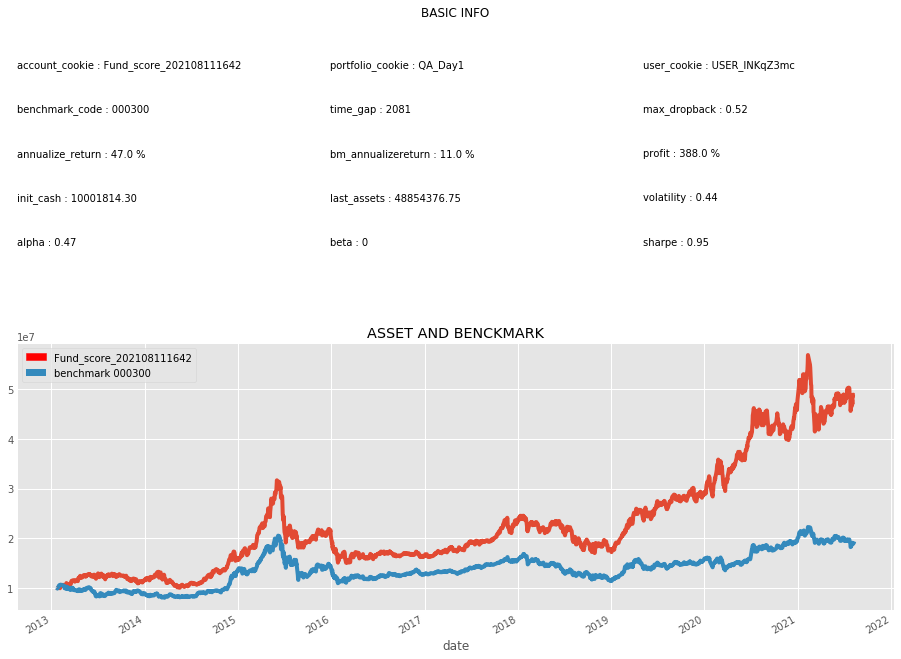

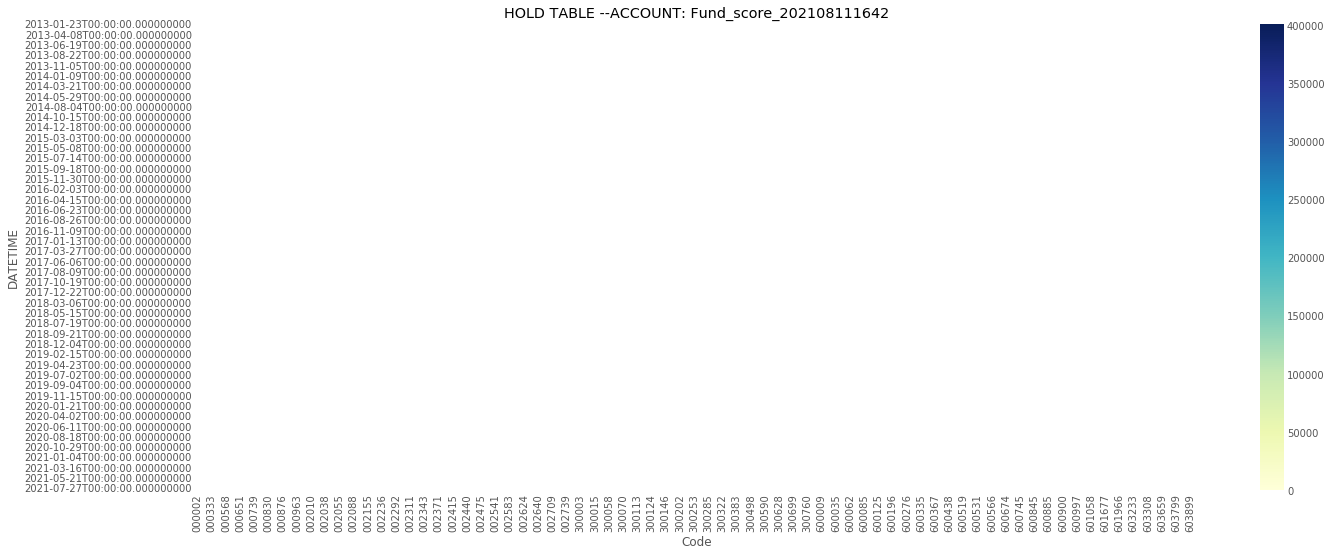

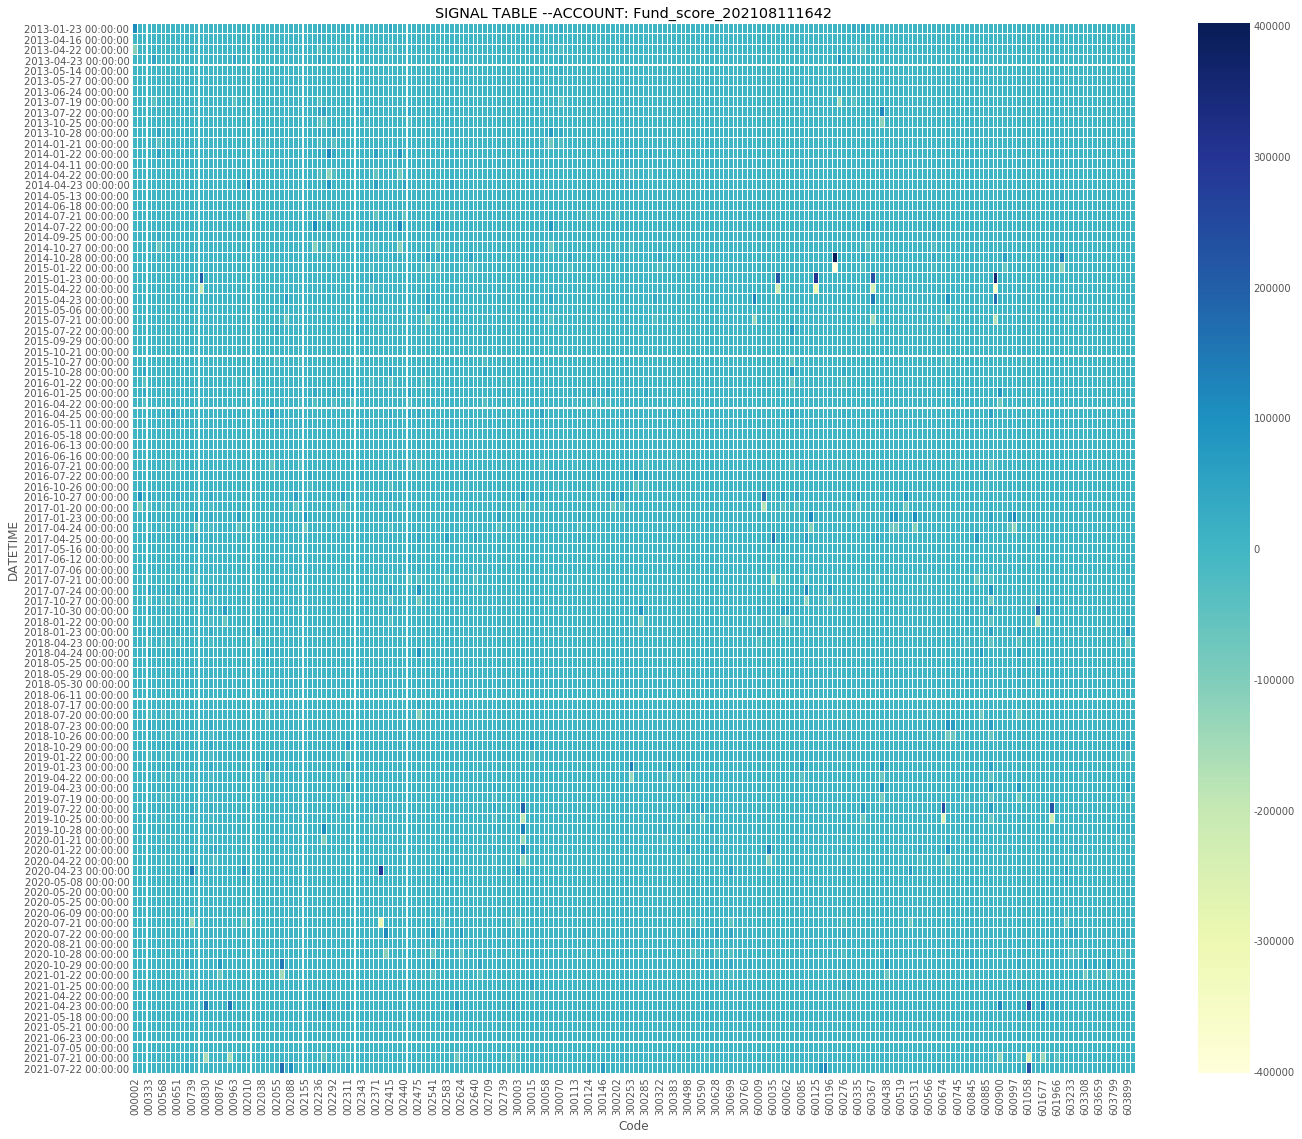

In [33]:
fig = risk.plot_assets_curve()
fig.show()
fig = risk.plot_dailyhold()
fig.show()
fig = risk.plot_signal()
fig.show()

# 构造优选基金的超配组合

## 超配股与指数成分股

In [34]:
# ---------------------------  展示优选基金组合超配股在沪深300 和中证500 指数中的分布
def analysis_index_cons(df):
    # 分析超配股是否为HS300、ZZ500成分股
    quarter_list = sorted(df['reportDate'].unique().tolist())
    cons_df = pd.DataFrame(index=quarter_list, columns=[u'沪深300成分股占比', u'中证500成分股占比', u'其他'])
    hs300_cons = pd.read_csv(raw_data_dir + 'hs300_con.csv', index_col=0, dtype=str)
    zz500_cons = pd.read_csv(raw_data_dir + 'zz500_con.csv', index_col=0, dtype=str)
    for quarter in quarter_list:
        hold_ticker_list = df.query("reportDate==@quarter")['holdingTicker'].tolist()
        hs300_cons_list = hs300_cons.query('reportDate==@quarter')['consTickerSymbol'].tolist()
        zz500_cons_list = zz500_cons.query('reportDate==@quarter')['consTickerSymbol'].tolist() 
#         print(hold_ticker_list)
#         print(hs300_cons_list)
        
        hs300_pert = len(set(hold_ticker_list) & set(hs300_cons_list)) * 1.0 / len(hold_ticker_list)
        zz500_pert = len(set(hold_ticker_list) & set(zz500_cons_list)) * 1.0 / len(hold_ticker_list)
        cons_df.loc[quarter] = [hs300_pert, zz500_pert, 1-hs300_pert-zz500_pert]

    return cons_df

In [35]:
cons_df = analysis_index_cons(top10mean_10_hold_info)

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)

cons_df.plot(kind='bar', ax=ax1, legend=False, stacked=True)
ax1.legend(cons_df.columns, prop=font, loc='upper right', bbox_to_anchor=(1.2, 0.5), handlelength=2, handletextpad=1, borderpad=0.5)

ax1.set_yticklabels([str(round(x, 2) * 100) + '%' for x in ax1.get_yticks()], fontproperties=font, fontsize=14)
ax1.set_title(u'优选基金组合超配股在沪深300 和中证500 指数中的分布', fontproperties=font, fontsize=16)
ax1.grid()
plt.show()

NameError: name 'top10mean_10_hold_info' is not defined